# Load data

In [18]:
def ind(pd_arr):
    
    ori_arr=np.array(pd_arr,dtype=type(pd_arr[0]))
    set_arr=sorted(pd_arr.unique())   
    ind_arr=np.zeros_like(ori_arr,dtype=int)
    
    for j in range(len(set_arr)):
        ind_arr[(ori_arr==set_arr[j]).nonzero()[0]]=j

    return set_arr,ind_arr

bouton_info=pd.read_csv("bouton_table")
_=bouton_info.pop("Unnamed: 0")
bouton_info.index=bouton_info.pop("bouton_ind").astype(int)
b_table=bouton_info.values[:,:3]
bouton_n=len(bouton_info)
bouton_Type_set,bouton_Type_ind=ind(bouton_info.index)

claw_info=pd.read_csv("claw_table")
_=claw_info.pop("Unnamed: 0")
claw_info.index=claw_info.pop("KC_ind").astype(int)
c_table=claw_info.values[:,:3] ### spatial information of each claw
claw_n=len(claw_info)
claw_Type_set,claw_Type_ind=ind(claw_info.index)


In [19]:
b2c_dis=np.loadtxt("bouton2claw_dis")
# dis=np.loadtxt("claw2claw_dis")

# b2c_dis=np.zeros((bouton_n,claw_n))
# for i in range(bouton_n):
#     for j in range(claw_n):
#         b2c_dis[i,j]=sum((b_table[i]-c_table[j])**2)**0.5

dis=np.zeros((claw_n,claw_n),dtype=np.int16)
for i in range(claw_n):
    for j in range(i,claw_n):
        dis[i,j]=round(sum((c_table[i]-c_table[j])**2)**0.5)
dis+=dis.T

KeyboardInterrupt: 

In [2]:
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
from numpy.linalg import eig
import random
import os

### Load data
os.chdir("/prousr/lscheng/Axel/KC_G_table_list_52G")
type_list = pd.read_excel('type_list.xlsx')
PN2KC_data = pd.read_excel('PN_to_KC_connection-ver1_2.xlsx')
PN2KC_data = PN2KC_data.drop(columns=['Unnamed: 0'], errors='ignore')

### Data cleaning 
# Remove connections with weight < 5 and non-olfactory and multi-glomeruli
PN2KC_data_cleaned = PN2KC_data[PN2KC_data['w.weight'] >= 3]
PN2KC_data_cleaned['up.type'] = PN2KC_data_cleaned['up.type'].replace({'VM4_lvPN': 'lvVM4_lvPN'})
PN2KC_data_cleaned = PN2KC_data_cleaned[PN2KC_data_cleaned['up.type'].isin(type_list['PN_Type_Set_2'])]
PN2KC_data_cleaned['num'] = 1


KC_types = PN2KC_data_cleaned['down.type'].unique()
KC_class_subtype_map = {ki:ki[:ki.index('-')] for ki in KC_types}
PN2KC_data_cleaned['down.type (class)'] = PN2KC_data_cleaned['down.type'].map(KC_class_subtype_map)
PN2KC_data_cleaned['down.type (subtype)'] = PN2KC_data_cleaned['down.type']
PN2KC_data_cleaned = PN2KC_data_cleaned[['up.bodyId', 'up.type', 'down.bodyId', 'down.type (class)', 'down.type (subtype)', 'w.weight','num']].reset_index(drop=True)

# Define glomeruli and KC subtypes 
glomeruli_types = PN2KC_data_cleaned['up.type'].unique()
KC_ids = PN2KC_data_cleaned['down.bodyId'].unique()

# KC classification
KC_classes = ['KCg', "KCa'b'", 'KCab']
KC_subtypes = ['KCg-d', 'KCg-m', 'KCg-s4', 'KCg-t',
               "KCa'b'-ap1", "KCa'b'-ap2", "KCa'b'-m", 
               'KCab-p', 'KCab-m', 'KCab-s', 'KCab-c']
KC_subtype_groups = [
    ['KCg-d', 'KCg-m', 'KCg-s4', 'KCg-t'],
    ["KCa'b'-ap1", "KCa'b'-ap2", "KCa'b'-m"], 
    ['KCab-p', 'KCab-m', 'KCab-s', 'KCab-c']
]

KC_id_to_type = PN2KC_data_cleaned[['down.bodyId', 'down.type (class)', 'down.type (subtype)',]].drop_duplicates()
KC_id_to_type.index = KC_id_to_type.pop('down.bodyId')

# Add random location data for testing purposes
PN2KC_data_cleaned['location'] = [np.random.uniform(-10, 10, 3) for _ in range(len(PN2KC_data_cleaned))]


/prousr/lscheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [31]:
PN2KC_data_cleaned

,up.bodyId,up.type,down.bodyId,down.type (class),down.type (subtype),w.weight,num,location
0,724816115,DP1l_adPN,487834111,KCa'b',KCa'b'-ap1,15,1,"[-9.670439136036833, 6.9969342982179725, 5.386..."
1,1700946301,DL1_adPN,5813062565,KCa'b',KCa'b'-ap1,20,1,"[-3.269823576613815, -7.4216517467195064, 9.84..."
2,693483018,DL5_adPN,5813062565,KCa'b',KCa'b'-ap1,12,1,"[-3.7185654890640425, -9.286589703766143, 7.47..."
3,606090268,VC1_lPN,5813062565,KCa'b',KCa'b'-ap1,16,1,"[-6.095364236771983, -1.048732370746805, 4.149..."
4,1944507292,VL2p_adPN,5813021822,KCa'b',KCa'b'-ap1,26,1,"[-2.404462952360009, -5.2660120161436685, -2.5..."
...,...,...,...,...,...,...,...,...
9650,1944507292,VL2p_adPN,5812982874,KCg,KCg-t,31,1,"[-1.454659075825429, 7.351829413450307, 9.6156..."
9651,1882083076,VA7m_lPN,5812982874,KCg,KCg-t,20,1,"[-8.95206851383071, -9.751228227611396, 9.8238..."
9652,2064165421,V_ilPN,5812979121,KCg,KCg-t,3,1,"[-3.714960456151342, -8.604790375643038, 0.665..."
9653,724816115,DP1l_adPN,5812979121,KCg,KCg-t,34,1,"[4.124451804295843, 3.825023586687813, -2.6943..."


# Function

In [32]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle

import pandas as pd
import numpy as np

def random_shuffle_PN2KC(data, shuffle_ratio=1.0, within_type=False):
    """
    Perform random shuffling of PN2KC data, with optional within-type constraints.

    Parameters:
    - data (pd.DataFrame): Original PN2KC data to shuffle.
    - shuffle_ratio (float): Proportion of data to shuffle (0 to 1).
    - within_type (str or bool): Shuffle within the same KC type ('class', 'subtype', or False for no restriction).

    Returns:
    - pd.DataFrame: Randomly shuffled PN2KC data.
    """
    shuffled_data = data.copy()
    shuffle_count = int(len(data) * shuffle_ratio)
    
    if shuffle_count > 0:
        if within_type in ['class', 'subtype']:
            column = f'down.type ({within_type})'
            unique_types = shuffled_data[column].unique()
            
            for kc_type in unique_types:
                # Select rows belonging to the current KC type
                type_indices = shuffled_data[shuffled_data[column] == kc_type].index
                if len(type_indices) > 1:  # Only shuffle if there are multiple rows
                    shuffled_data.loc[type_indices, 'up.type'] = np.random.permutation(
                        shuffled_data.loc[type_indices, 'up.type']
                    )
        else:
            # Shuffle without type restriction
            indices_to_shuffle = np.random.choice(data.index, size=shuffle_count, replace=False)
            shuffled_data.loc[indices_to_shuffle, 'up.type'] = np.random.permutation(
                shuffled_data.loc[indices_to_shuffle, 'up.type']
            )
    
    return shuffled_data

# def spatial_shuffle_PN2KC(data, claw_distance, threshold=500, within_type=False):
#     """
#     Perform spatial shuffling of PN2KC data using claw-to-claw distances.

#     Parameters:
#     - data (pd.DataFrame): Original PN2KC data to shuffle.
#     - claw_distance (np.ndarray): Distance matrix for claws (num_claws x num_claws).
#     - threshold (float): Maximum distance for spatial shuffling.
#     - within_type (str or bool): Shuffle within the same KC type ('class', 'subtype', or False for no restriction).

#     Returns:
#     - pd.DataFrame: Spatially shuffled PN2KC data.
#     """
#     shuffled_data = data.copy()
    
#     for claw_idx in range(len(data)):
#         # Find indices of nearby claws
#         nearby_indices = np.where((claw_distance[claw_idx] < threshold) & (claw_distance[claw_idx] > 0))[0]
        
#         if within_type in ['class', 'subtype']:
#             column = f'down.type ({within_type})'
#             claw_type = shuffled_data.iloc[claw_idx][column]
#             nearby_indices = [idx for idx in nearby_indices if shuffled_data.iloc[idx][column] == claw_type]
        
#         if len(nearby_indices) > 0:
#             # Swap the 'up.type' of current claw with a randomly selected nearby claw
#             swap_idx = np.random.choice(nearby_indices)
#             shuffled_data.at[claw_idx, 'up.type'], shuffled_data.at[swap_idx, 'up.type'] = (
#                 shuffled_data.at[swap_idx, 'up.type'],
#                 shuffled_data.at[claw_idx, 'up.type']
#             )
    
#     return shuffled_data


def aggregate_PN2KC_data(data, aggregate_by_KC_type=None):
    """
    Aggregate the PN2KC data based on KC class or subtype.
    
    Parameters:
    - data (pd.DataFrame): PN2KC data to be aggregated.
    - aggregate_by_KC_type (str): Aggregation method ('class' or 'subtype').
    
    Returns:
    - DataFrame: Aggregated PN2KC data with glomeruli as rows and KC classes/subtypes as columns.
    """
    if aggregate_by_KC_type:
        column = f'down.type ({aggregate_by_KC_type})'
        aggregation = data.groupby(['up.type', column]).agg({'num': 'sum', 'w.weight': 'sum'})
        aggregated = aggregation.reset_index().pivot(index='up.type', columns=column, values=['num', 'w.weight'])

        return aggregated

    return data


def aggregate_PN2KC_data(data, aggregate_by_KC_type=None):
    """
    Aggregate the PN2KC data based on KC class or subtype.
    
    Parameters:
    - data (pd.DataFrame): PN2KC data to be aggregated.
    - aggregate_by_KC_type (str or None): Aggregation method ('class', 'subtype', or None).
    
    Returns:
    - aggregated_con_matrix (pd.DataFrame): Connection matrix with glomeruli as rows and KC classes/subtypes as columns.
    - aggregated_syn_matrix (pd.DataFrame): Synapse weight matrix with glomeruli as rows and KC classes/subtypes as columns.
    """
    if aggregate_by_KC_type:
        column = f'down.type ({aggregate_by_KC_type})'
        aggregation = data.groupby(['up.type', column]).agg({'num': 'sum', 'w.weight': 'sum'}).reset_index()

        # Pivot to create separate connection and synapse matrices
        aggregated_con_matrix = aggregation.pivot(index='up.type', columns=column, values='num').fillna(0)
        aggregated_syn_matrix = aggregation.pivot(index='up.type', columns=column, values='w.weight').fillna(0)

        return aggregated_con_matrix, aggregated_syn_matrix
    else:
        # If no aggregation is required, raise an exception or return None
        raise ValueError("aggregate_by_KC_type must be specified as 'class' or 'subtype'.")

def generate_connection_matrix(PN2KC, glomeruli_types, kc_indices):
    """
    Constructs connection and synapse matrices from PN2KC DataFrame.
    
    Parameters:
    - PN2KC: DataFrame with columns 'up.type' (glomeruli type), 'down.bodyId' (KC ID), 
             'w.weight' (synapse weight), and 'num' (number of synapses).
    - glomeruli_types: List of glomeruli types.
    - kc_indices: List of Kenyon Cell indices.
    
    Returns:
    - con_matrix: Connection matrix (KC x glomeruli).
    - syn_matrix: Synapse matrix (KC x glomeruli).
    """
    con_matrix = pd.DataFrame(np.zeros((len(kc_indices), len(glomeruli_types))), index=kc_indices, columns=glomeruli_types, dtype=int)
    syn_matrix = pd.DataFrame(np.zeros((len(kc_indices), len(glomeruli_types))), index=kc_indices, columns=glomeruli_types, dtype=int)

    for g_type in glomeruli_types:
        df = PN2KC[PN2KC['up.type'] == g_type][['down.bodyId', 'w.weight', 'num']]
        grouped_df = df.groupby('down.bodyId').sum()
        con_matrix.loc[grouped_df.index, g_type] += grouped_df['num']
        syn_matrix.loc[grouped_df.index, g_type] += grouped_df['w.weight']

    return con_matrix, syn_matrix

def calculate_eigenvalue_stats(matrix):
    """
    Compute eigenvalue statistics of a matrix.
    
    Parameters:
    - matrix: Input matrix.
    
    Returns:
    - Eigenvalue array normalized to sum to 1.
    """
    corr_matrix = np.corrcoef(matrix.T)
    eigenvalues = np.sort(np.abs(np.linalg.eigvals(corr_matrix)))[::-1]
    eigenvalues /= eigenvalues.sum()
    return eigenvalues


In [33]:
import matplotlib.pyplot as plt

# Example 1: Random shuffling with 10% of data
shuffled_data_random = random_shuffle_PN2KC(
    data=PN2KC_data_cleaned,
    shuffle_ratio=0.1,
    within_type=False
)

# # Example 2: Spatial shuffling within a 5-unit radius, only among the same KC classes
# shuffled_data_spatial_within_class = shuffle_PN2KC_data(
#     data=PN2KC_data_cleaned,
#     shuffle_ratio=0.2,
#     shuffle_type='spatial',
#     radius=5,
#     within_type='class'
# )

# # Example 3: Spatial shuffling within a 5-unit radius, only among the same KC subtypes
# shuffled_data_spatial_within_subtype = shuffle_PN2KC_data(
#     data=PN2KC_data_cleaned,
#     shuffle_ratio=0.2,
#     shuffle_type='spatial',
#     radius=5,
#     within_type='subtype'
# )

# Example 4: Aggregation by KC class
aggregated_con_by_KC_class,aggregated_syn_by_KC_class = aggregate_PN2KC_data(
    data=PN2KC_data_cleaned,
    aggregate_by_KC_type='class'
)

# Example 5: Aggregation by KC subtype
aggregated_con_by_KC_subtype,aggregated_syn_by_KC_subtype = aggregate_PN2KC_data(
    data=PN2KC_data_cleaned,
    aggregate_by_KC_type='subtype'
)

# Example 6: Generate connection and synapse matrices from the shuffled data
con_matrix, syn_matrix = generate_connection_matrix(
    PN2KC_data_cleaned, 
    glomeruli_types=glomeruli_types, 
    kc_indices=KC_ids
)

# Example 7: Calculate the eigenvalue of connection matrix
con_eigvalue = calculate_eigenvalue_stats(con_matrix)


# Display results
print("Random Shuffle (10%):")
print(shuffled_data_random.head())

# print("\nSpatial Shuffle within KC Class (5-unit radius):")
# print(shuffled_data_spatial_within_class.head())

# print("\nSpatial Shuffle within KC Subtype (5-unit radius):")
# print(shuffled_data_spatial_within_subtype.head())

print("\nAggregated by KC Class:")
print(aggregated_con_by_KC_class.head())

print("\nAggregated by KC Subtype:")
print(aggregated_syn_by_KC_subtype.head())

print("\nShuffled Connection Matrix:")
print(con_matrix.head())

print("\nEigenvalue of connection matrix:")
print(con_eigvalue)

Random Shuffle (10%):
    up.bodyId    up.type  down.bodyId down.type (class) down.type (subtype)  \
0   724816115  DP1l_adPN    487834111            KCa'b'          KCa'b'-ap1   
1  1700946301   DL1_adPN   5813062565            KCa'b'          KCa'b'-ap1   
2   693483018   DL5_adPN   5813062565            KCa'b'          KCa'b'-ap1   
3   606090268   VA3_adPN   5813062565            KCa'b'          KCa'b'-ap1   
4  1944507292  VL2p_adPN   5813021822            KCa'b'          KCa'b'-ap1   

   w.weight  num                                           location  
0        15    1  [-9.670439136036833, 6.9969342982179725, 5.386...  
1        20    1  [-3.269823576613815, -7.4216517467195064, 9.84...  
2        12    1  [-3.7185654890640425, -9.286589703766143, 7.47...  
3        16    1  [-6.095364236771983, -1.048732370746805, 4.149...  
4        26    1  [-2.404462952360009, -5.2660120161436685, -2.5...  

Aggregated by KC Class:
down.type (class)  KCa'b'  KCab    KCg
up.type            

In [29]:
PN2KC_data_cleaned

,up.bodyId,up.type,down.bodyId,down.type (class),down.type (subtype),w.weight,num,location
0,724816115,DP1l_adPN,487834111,KCa'b',KCa'b'-ap1,15,1,"[0.15325473760013075, 9.065317135702205, -3.74..."
1,1700946301,DL1_adPN,5813062565,KCa'b',KCa'b'-ap1,20,1,"[-1.0063860865488898, 0.3284881264077999, -7.7..."
2,693483018,DL5_adPN,5813062565,KCa'b',KCa'b'-ap1,12,1,"[-0.9685126313073678, -6.217095119738827, 2.13..."
3,606090268,VC1_lPN,5813062565,KCa'b',KCa'b'-ap1,16,1,"[2.1234928276332727, 7.04127439128532, 1.84061..."
4,1944507292,VL2p_adPN,5813021822,KCa'b',KCa'b'-ap1,26,1,"[9.856910837997226, 5.687571555958401, 4.73591..."
...,...,...,...,...,...,...,...,...
9650,1944507292,VL2p_adPN,5812982874,KCg,KCg-t,31,1,"[-5.434334918999095, 8.578888143661075, 3.3184..."
9651,1882083076,VA7m_lPN,5812982874,KCg,KCg-t,20,1,"[6.33445761869449, 0.3936939897388054, -7.8627..."
9652,2064165421,V_ilPN,5812979121,KCg,KCg-t,3,1,"[1.8672897495224952, -8.544695704772087, 3.093..."
9653,724816115,DP1l_adPN,5812979121,KCg,KCg-t,34,1,"[9.673004971885458, 1.4397956890286743, -4.352..."


In [45]:
def calculate_preference_score(PN2KC_data=PN2KC_data_cleaned,trials=1000,shuffling_method='random',shuffle_ratio=1,aggregate_by='KC_class',KC_id_to_type=KC_id_to_type,KC_type_list=KC_subtype_groups):
    """
    Calculate preference scores for KC subtypes with respect to glomeruli based on shuffled and aggregated data.
    
    Parameters:
    PN2KC_data (DataFrame): Original KC-to-glomeruli connection data.
    KC_type_list (list of lists): Defines KC subtypes within KC groups.
    trials (int): Number of trials for shuffled control comparisons.
    shuffling_method (str): 'random' or 'spatial' shuffling method.
    shuffle_ratio (float): Proportion of data to shuffle.
    aggregate_by (str): Aggregation method ('KC_class' or 'KC_subtype').
    
    Returns:
    np.ndarray: Preference score matrix with each row representing a KC group.
    """
    num_glomeruli = PN2KC_data['up.type'].nunique()
    preference_scores = np.zeros((len(KC_type_list), num_glomeruli))
    
    # Shuffle data if specified
    shuffled_data = shuffle_PN2KC_data(
        PN2KC_data,
        shuffle_type=shuffling_method,
        shuffle_ratio=shuffle_ratio
    )

    # Aggregate the shuffled data by KC class or subtype
    aggregated_data = aggregate_PN2KC_data(
        data=shuffled_data,
        aggregate_by_KC_type=aggregate_by
    )

    for i, kc_group in enumerate(KC_type_list):
        # Identify the indices for the current KC group
        target_kc_indices = KC_id_to_type['down.type'].isin(kc_group).values
        observed_preference = aggregated_data[target_kc_indices].sum()
        observed_preference /= observed_preference.sum()

        # Shuffling trials to get distribution for control
        shuffled_preferences = np.zeros((trials, num_glomeruli))
        for j in range(trials):
            # Shuffle data to create a random distribution for this trial
            shuffled_data_trial = shuffle(aggregated_data).iloc[:sum(target_kc_indices)[0]].sum()
            shuffled_preferences[j] = shuffled_data_trial

        # Calculate mean and standard deviation of the shuffled trials
        mean_shuffled = shuffled_preferences.mean(axis=0)
        std_shuffled = shuffled_preferences.std(axis=0)
        normalization_factor = mean_shuffled.sum()

        # Compute the preference score
        preference_scores[i] = (observed_preference - mean_shuffled / normalization_factor) / (std_shuffled / normalization_factor)
    
        # Estimate remaining time after each KC group is processed
        elapsed_time = time.time() - start_time
        estimated_time_remaining = (len(KC_type_list) - (i + 1)) * (elapsed_time / (i + 1))
        print(f"Estimated time remaining: {estimated_time_remaining / 60:.2f} minutes")

    return preference_scores


Fig. 1. Preferential connectivity between olfactory PNs and three classes of KCs.

(A) The connectivity matrix of PN-to-KC synapses derived from the hemibrain dataset (32) .

In [ ]:
plt.figure(figsize=(10.8,6.9))
g = sns.heatmap(s_G2KCsub_con.iloc[:,pref_score.g_sort.values].loc[_],yticklabels=False,
            xticklabels=False,cmap='jet',cbar=False)
# colorbar = g.collections[0].colorbar
# colorbar.set_ticks(np.arange(4))
# colorbar.set_ticklabels(range(4))
plt.hlines([607,335+607],0,52,color='white')
plt.vlines([20,20+17],0,1750,color='white')
plt.xticks([20/2,20+17/2,20+17+15/2],['Cluster 1', 'Cluster 2','Cluster 3',], fontsize=12)

plt.yticks([607/2,607+335/2,607+335+803/2],[r'$\gamma$',r"$\alpha'\beta'$",r"$\alpha\beta$"], fontsize=12)
plt.show()

(B) The connection preferences indicated by the G i score between a KC class i (i = γ, α’/β’, or α/β) and PNs from a particular glomerulus.

In [46]:
# Example of preference score

pref_score = calculate_preference_score(PN2KC_data=PN2KC_data_cleaned, 
                           trials=1000, 
                           shuffling_method='random', 
                           shuffle_ratio=1, 
                           aggregate_by='KC_class',
                           KC_id_to_type=KC_id_to_type,
                           KC_type_list=KC_subtype_groups)


xticks_colors = pref_score['cluster'].map(dict(zip(range(3), ['r', 'goldenrod', 'deepskyblue'])))
xticks_colors.index = pref_score.index
labels = [r"$\gamma$", r"$\alpha'\beta'$", r"$\alpha\beta$"]

plt.figure(figsize=(11, 8))
sorted_data = pref_score.iloc[:, :3].sort_values(by='pref_con_g', ascending=False)
food_type = type_list['(Zheng, 2020)']
food_type.index = type_list.PN_Type_Set_short
food_type = food_type[sorted_data.index]
food_type['V'] = 0

xtick_labels = food_type.index.tolist()
color_labels = xticks_colors.copy()
color_labels[xticks_colors == 'peru'] = 'yellow'

for i in np.where(food_type == 0)[0]:
    xtick_labels[i] += r'$\bullet$'

for i, col_name in enumerate(sorted_data):    
    ax = plt.subplot(311 + i)
    ax.bar(range(52), sorted_data[col_name], color='k')
    ax.set_xticklabels([])
    plt.ylim(-10, 13.5)
    ax.spines['bottom'].set_linewidth(0)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(0)
    ax.set_xticklabels(ax.get_xticks(), weight='bold')
        
    if i == 0:
        plt.vlines([20 - 0.5, 37 - 0.5], -10, 13.5, linestyles='dashed', colors='grey')
        ax.spines['top'].set_linewidth(2)    
        ax.set_xticks(range(52))
        ax.set_xticklabels(xtick_labels, fontsize=10, rotation=90)
        ax.xaxis.set_ticks_position('top')

        for xtick, color in zip(ax.get_xticklabels(), color_labels[sorted_data.index].values):
            xtick.set_color(color)
    else:
        ax.spines['top'].set_linewidth(0)
        ax.get_xaxis().set_visible(False)

plt.show()


ValueError: Item wrong length 1745 instead of 52.

Fig. 3. Preferential functional connectivity between PNs and KCs. 

In [5]:
DoOr_resp = pd.read_csv("DoOr_reponse_matrix.csv")
DoOr_resp.index = DoOr_resp.pop("Unnamed: 0")

DoOr_resp_ori = pd.read_csv("DoOr_reponse_matrix_origine.csv")
DoOr_resp_ori.index = DoOr_resp_ori.pop("Unnamed: 0")

type_list = pd.read_excel("type_list.xlsx")
_ = type_list.pop("Unnamed: 0")


In [6]:
l = pd.Series(np.zeros(52))
for ti in [ 'DM3','VA3']:
    l += (type_list['PN_Type_Set_short'] == ti)
table = DoOr_resp_ori[type_list[l.astype(bool)]['Or']].dropna(how='any')
table

,Or47a,Or67b
Unnamed: 0,,
SFR,0.051946,0.050915
QTBSBXVTEAMEQO-UHFFFAOYSA-N,0.042834,0.185503
XBDQKXXYIPTUBI-UHFFFAOYSA-N,0.010782,0.126231
FERIUCNNQQJTOY-UHFFFAOYSA-N,0.084340,0.191908
NQPDZGIKBAWPEJ-UHFFFAOYSA-N,0.075589,0.107384
...,...,...
OBNCKNCVKJNDBV-UHFFFAOYSA-N,0.307642,0.067552
XAPCMTMQBXLDBB-UHFFFAOYSA-N,0.084340,0.385612
YLYBTZIQSIBWLI-UHFFFAOYSA-N,0.084348,0.095480


In [7]:
d = list(DoOr_resp.columns)
t = type_list['Or'].to_list()

DoOr_map2_type = [] ### DoOr_resp map to type_list
for oi in d:
    if oi in t: 
        DoOr_map2_type.append(t.index(oi))
    else: 
        DoOr_map2_type.append(-9999)
DoOr_map2_type = np.array(DoOr_map2_type)

t_i = np.zeros_like(DoOr_map2_type, dtype=object)
t_i[DoOr_map2_type == -9999] = 'other'
t_i[DoOr_map2_type != -9999] = (type_list['PN_Type_Set_short'].values)[DoOr_map2_type[DoOr_map2_type != -9999]]


In [9]:
# row_colors = pd.read_excel('row_colors_info.xlsx')

lut = dict(zip(np.arange(4), ['deepskyblue','yellow','red','brown']))
row_colors = type_list['cluster_connection'].map(lut)
colors = np.zeros_like(DoOr_map2_type, dtype=object)
colors[DoOr_map2_type == -9999] = 'lightgray'
colors[DoOr_map2_type != -9999] = row_colors[DoOr_map2_type[DoOr_map2_type != -9999]]

# rc = row_colors[['z-score cluster','cluster_connection']]
or_list = ['Or46a','Or47b','Ir76a','Ir92a','Or88a','Ir75d','Ir41a','Or69a',
          'Ir84a','Or10a','Or49b','Or71a','Or33c','Ir31a','Or82a','Or65a',
          'Or83c','Or7a','Or67b','Or42a','Or92a','Or42b','Or59b','Or49a','Or85d',
          'Or59c','Or67a','Or85a','Or67c','Or9a','Or43b','Or43a','Or23a','Or35a','Or19a',
          'Or22a','Or2a','Or47a','Or98a','Or13a','Or85b']

(B) The correlation matrix of ORN odorant responsive profiles.

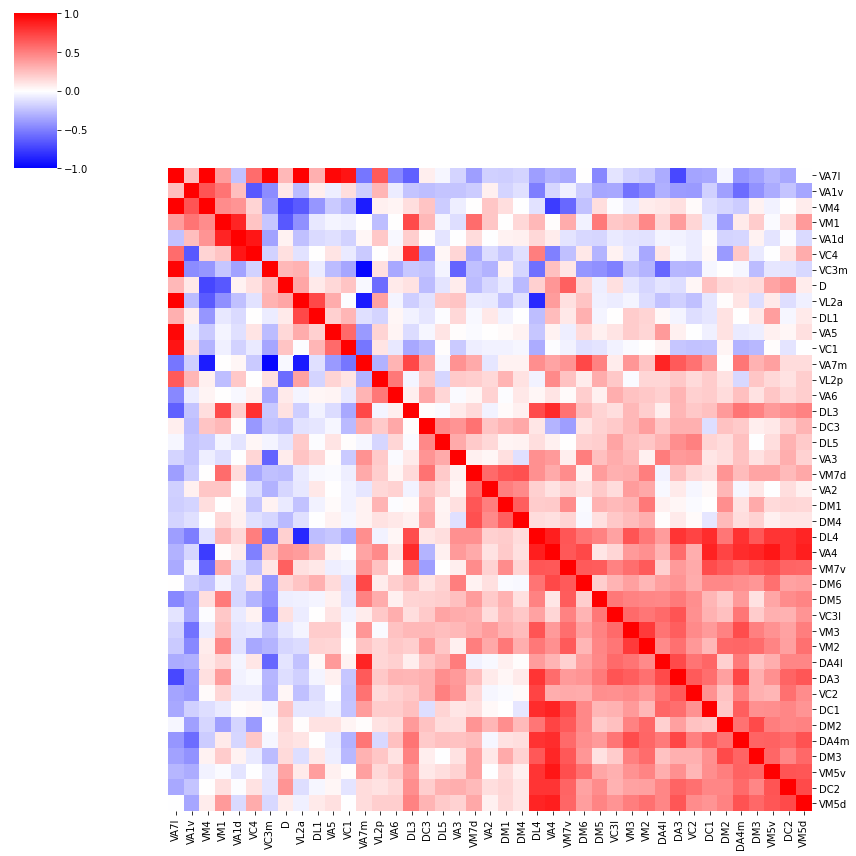

In [10]:
import seaborn as sns

method = "single"

table = DoOr_resp_ori.corr()
table = table[or_list].T[or_list].T
table.index= range(len(table))
table = table.dropna(axis=0,how='all').dropna(axis=1,how='all')

x1 = ['VA7l','VA1v','VM4','VM1','VA1d','VC4','VC3m','D',
'VL2a','DL1','VA5','VC1','VA7m','VL2p','VA6','DL3',
'DC3','DL5','VA3','VM7d','VA2','DM1','DM4','DL4','VA4',
'VM7v','DM6','DM5','VC3l','VM3','VM2','DA4l','DA3',
'VC2','DC1','DM2','DA4m','DM3','VM5v','DC2','VM5d'];

g = sns.clustermap(table,method=method,cmap='bwr',figsize=(12,12),
                   vmin=-1,xticklabels=x1,yticklabels=x1,col_cluster=False,row_cluster=False) 

(A) The most sensitive odorant for each glomerulus, based on the DoOR database.

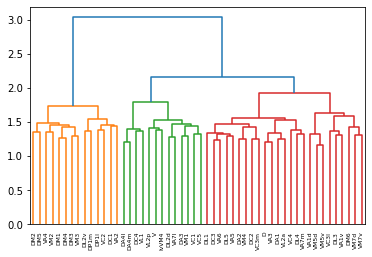

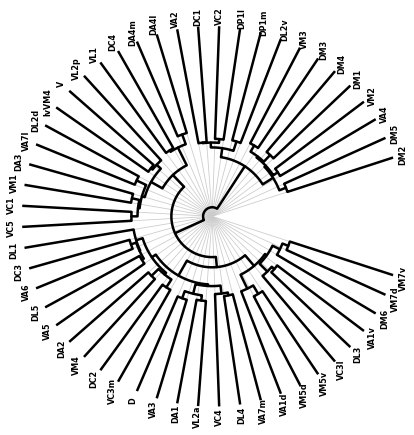

In [18]:
from scipy.cluster.hierarchy import average, dendrogram, leaves_list, linkage

def norm_cov(KC):
    KC=np.array(KC)
    KC_t=np.zeros_like(KC.T)
    for i in range(len(KC.T)):
        ki=KC[:,i]
        if sum(ki)==0:
            continue
        else:
            ki-=np.mean(ki)
            KC_t[i]=ki/(np.inner(ki,ki)**0.5)

    cov=np.cov(KC_t)*(len(KC)-1)
    return cov
            
def smoothsegment(seg, Nsmooth=100):
    return np.concatenate([[seg[0]], np.linspace(seg[1], seg[2], Nsmooth), [seg[3]]])

def plot_dendrogram(icoord,dcoord,figsize, color="k", polar=False):
    if polar:
        dcoord = -np.log(dcoord+1)
        # avoid a wedge over the radial labels
        gap = 0.1
        imax = icoord.max()
        imin = icoord.min()
        icoord = ((icoord - imin)/(imax - imin)*(1-gap) + gap/2)*2*np.pi
    with plt.style.context("seaborn-white"):
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, polar=polar)
        for xs, ys in zip(icoord, dcoord):
            if polar:
                xs = smoothsegment(xs)
                ys = smoothsegment(ys)
#             ax.plot(xs,ys,color=color)
            p1 = ax.plot(xs,ys,color=color,linewidth=2.5)

#         ax.set_title("Pair ligands of olfaction-related glomeruli", fontsize=12)
        if polar:
            ax.spines['polar'].set_visible(False)
            ax.set_rticks([]) 
            ax.set_xticks([]) 
#             ax.grid(True)

            Nxticks = 52
            xticks = np.linspace(gap/2, 1-gap/2, Nxticks)
            ax.set_xticks(xticks*np.pi*2)
            ax.set_xticklabels(deng["ivl"],fontsize=8,color=color,weight='bold')
            ax.tick_params(axis='x', labelrotation=90)

#             ax.set_xticklabels(type_list["associated ligand"][deng["leaves"]]
# ,fontsize=8)
    
#     plt.savefig('mol_glo.png',transparent = True)

PN_Type_set_olf_short=pd.read_csv("PN_Type_set_olf_short")
_=PN_Type_set_olf_short.pop("Unnamed: 0")

p=[]
for pi in PN_Type_set_olf_short.values:
    p.append(pi[0])
PN_Type_set_olf_short=p

KC_G_table_list = [np.loadtxt("KC_G_table_"+n) for n in ["g","a'b'","ab"]]
KC_G_table_all=[]
for ki in KC_G_table_list:
    KC_G_table_all += list(ki)
KC_G_table_all=np.array(KC_G_table_all)

table = pd.DataFrame(norm_cov(KC_G_table_all))
linked = linkage(table, 'ward')
deng = dendrogram(linked,
            orientation='top',
            labels=PN_Type_set_olf_short,
            distance_sort='descending',
            color_threshold=2,
            show_leaf_counts=True)

icoord = np.asarray(deng["icoord"], dtype=float)
dcoord = np.asarray(deng["dcoord"], dtype=float)
figsize=(7,7)

plot_dendrogram(icoord,dcoord,figsize,color="k", polar=True)


(C) Experimental validation (upper panel) of predicted (lower panel) functional calcium responses ($\Delta$F/F) to eight odorants (see Methods) at β, γ, β’-m and β’-ap MB lobes.

Hemibrain

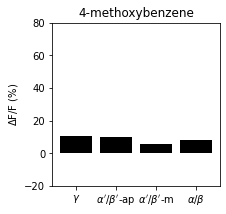

array([10.32233568,  9.87015574,  5.76829613,  7.9541728 ])

In [72]:
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
odor = pd.read_excel('odor.xlsx').set_index('Unnamed: 0')
DoOr = pd.read_csv('DoOr_reponse_matrix_origine.csv').set_index('Unnamed: 0')
corr = pd.read_excel('DoOr_only_olf.xlsx').set_index('Unnamed: 0')
ORN_G_map = pd.DataFrame({'ORN': corr.columns, 'G': corr.index})

col_colors = pd.read_excel('col_colors.xlsx').set_index('Unnamed: 0')

odor['Class'] = odor['Class'].fillna('nan')

# Merge similar odor classes
class_merges = [['acids', 'acid'], ['esters', 'ester'], ['terpenes', 'terpene'], 
                ['sulfid', 'sulfide'], ['aromatics', 'arom']]
for merge_pair in class_merges:
    odor['Class'].replace(merge_pair[1], merge_pair[0], inplace=True)

con_df = pd.read_excel('con_df.xlsx').set_index('Unnamed: 0')
con_df.columns = [c.split('_')[0] for c in con_df.columns]

# Create odor class map
odor_class_map_0 = odor['Class']
odor_class_map_0.index = odor['InChIKey']  # Set index as 'InChIKey'

odor_class_map = odor_class_map_0.copy()
for merge_pair in class_merges:
    odor_class_map.replace(merge_pair[1], merge_pair[0], inplace=True)

# Filter target odors and ORNs
target_odors = odor_class_map.index[odor_class_map.index.isin(DoOr.index)]
target_ORNs = ORN_G_map.loc[ORN_G_map['ORN'].isin(DoOr.columns), 'ORN']
orn2g_only_door = pd.read_excel('orn2g_only_door.xlsx')

### Function Definitions

def compute_response(DoOr_matrix=DoOr, connection_df=con_df, normalize=True, threshold=-1):
    """
    Compute the KC response matrix given a DoOr stimulus-response matrix.

    Parameters:
        DoOr_matrix (pd.DataFrame): Stimulus-response matrix for ORNs.
        connection_df (pd.DataFrame): Connection matrix from ORNs to KCs.
        normalize (bool): Normalize KC response by total claw count.
        threshold (int): If -1, return full response matrix; else apply threshold.

    Returns:
        pd.DataFrame: KC response matrix.
    """
    # Filter and process DoOr matrix
    df = DoOr_matrix.loc[target_odors, target_ORNs].clip(lower=0)
    df.columns = orn2g_only_door['g']

    # Compute KC response
    kc_response = df.fillna(0) @ connection_df[df.columns].T
    if normalize:
        kc_response /= connection_df.T.sum()

    if threshold == -1:
        return kc_response
    else:
        thresholded_response = kc_response.copy()
        for i in range(len(kc_response)):
            response_row = kc_response.iloc[i]
            min_activity = response_row.sort_values(ascending=False).iloc[threshold - 1]
            thresholded_response.iloc[i][response_row < min_activity] = 0
        return thresholded_response

response_df = compute_response()

def effective_response(response_matrix=response_df, odor_name='4-methoxybenzene', 
                       kc_indices=[2, 1], plot_response=True, threshold=-1):
    """
    Calculate and optionally plot the effective KC response for a given odor.

    Parameters:
        response_matrix (pd.DataFrame): KC response matrix.
        odor_name (str): Name of the odor to analyze.
        kc_indices (list of int): Indices of KCs to include in the analysis.
        plot_response (bool): Plot the response bar chart.
        threshold (int): Activity threshold for KC response (not used in this version).

    Returns:
        np.ndarray: Array of effective KC responses.
    """
    odor_key = odor.loc[odor['Name'] == odor_name, 'InChIKey'].values[0]
    odor_response = response_matrix.loc[odor_key]

    kc_color_map = col_colors.iloc[:, 0][odor_response.index]
    normalization_factor = 41 / (41 - DoOr.loc[odor_key, orn2g_only_door['orn']].isnull().sum())

    kc_response = np.zeros(4)
    kc_groups = [
        ['r', 'tomato', 'pink', 'crimson', 'hotpink', 'palevioletred', 'lightcoral'], 
        ['yellow', 'gold'], 
        ['brown'], 
        ['cyan', 'cornflowerblue', 'royalblue', 'b']
    ]

    for idx, group in enumerate(kc_groups):
        target_kcs = kc_color_map.index[kc_color_map.isin(group)]
        kc_response[idx] = odor_response[target_kcs].mean()
    
    kc_response *= 100 * normalization_factor

    # Plot response if requested
    if plot_response:
        plt.figure(figsize=(0.75 * len(kc_indices), 3))
        x_labels = [r"$\gamma$", r"$\alpha'/\beta'$-ap", r"$\alpha'/\beta'$-m", r"$\alpha/\beta$"]
        plt.bar(np.array(x_labels)[kc_indices], kc_response[kc_indices], color='k')
        plt.ylabel(r'$\Delta$F/F (%)')
        plt.title(odor_name)
        plt.ylim(-20, 80)
        plt.show()

    return kc_response

# Example Usage
effective_response(kc_indices=[0, 1, 2, 3])


FAFB

In [37]:
FAFB_bouton_claw_connection = pd.read_csv('FAFB_bouton_claw_connection.csv')
FAFB_connection_table = pd.read_csv('FAFB_connection_table.csv').set_index('Unnamed: 0').T

In [41]:
intersection = list(set(FAFB_connection_table.columns).intersection(con_df.columns))
sym_diff = list(set(FAFB_connection_table.columns).symmetric_difference(con_df.columns))
sym_diff

['VP3', 'VP2', 'lvVM4', 'VP1']

In [47]:
FAFB_connection_table = FAFB_connection_table[intersection]

Unnamed: 0,VC4,DL2v,VM7v,DL5,VM3,VL2a,DM2,V,VM4,VA7l,...,VM7d,DL2d,VL2p,DL3,DM4,D,DM1,DC1,DA4m,DP1m
KCg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
KCg.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
KCg.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
KCg.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
KCg.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KCab.470,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
KCab.471,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
KCab.472,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
KCab.473,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0


In [19]:
fafb_kc_type_class = []
for ki in FAFB_connection_table.columns[1:]:
    if '.' in ki:
        fafb_kc_type_class.append(ki[:ki.index('.')])
    else:
        fafb_kc_type_class.append(ki)

In [58]:
FAFB_connection_table_class = np.zeros((3,FAFB_connection_table.shape[1]))
for i, k_type in enumerate(['KCg',"KCa'b'",'KCab']):
    indices = [i for i, value in enumerate(x) if value == k_type]
    FAFB_connection_table_class[i] = FAFB_connection_table.iloc[indices].sum()
    

In [61]:
FAFB_connection_table_class_df = pd.DataFrame(FAFB_connection_table_class,
                                              index=['KCg',"KCa'b'",'KCab'],
                                              columns=FAFB_connection_table.columns)
FAFB_connection_table_class_df

Unnamed: 0,DC3,VA5,DA2,D,DA1,VL2a,VA7l,VA7m,VA6,VM5d,...,DM3,VA2,DM5,DM4,DP1m,DM1,DM2,VP1,VP2,VP3
KCg,75.0,56.0,47.0,50.0,84.0,84.0,41.0,80.0,79.0,91.0,...,44.0,43.0,51.0,36.0,111.0,51.0,41.0,43.0,13.0,27.0
KCa'b',8.0,11.0,7.0,3.0,13.0,18.0,7.0,18.0,22.0,32.0,...,25.0,44.0,19.0,42.0,55.0,40.0,38.0,15.0,6.0,17.0
KCab,34.0,21.0,12.0,24.0,60.0,29.0,6.0,34.0,55.0,76.0,...,95.0,85.0,64.0,108.0,170.0,155.0,109.0,14.0,0.0,1.0


In [68]:
odor_response.index

NameError: name 'odor_response' is not defined

In [69]:
response_df

Unnamed: 0,487834111,5813062565,5813021822,862312670,5812982823,5813078323,5813078679,1201032707,5813068984,5813091021,...,911755444,1142019878,5812981046,5812982547,5812981989,1392655948,785918963,630731599,5812982874,5812979121
InChIKey,,,,,,,,,,,,,,,,,,,,,
SFR,0.0,0.035824,0.058347,0.026108,0.008870,0.065839,0.108381,0.064988,0.025831,0.0,...,0.048452,0.024226,0.087323,0.028159,0.052728,0.026703,0.076247,0.036212,0.080704,0.0
XLYOFNOQVPJJNP-UHFFFAOYSA-N,0.0,0.057473,0.069383,0.054395,0.020600,0.075745,0.069383,0.085767,0.028367,0.0,...,0.000000,0.000000,0.100730,0.000000,0.039100,0.031358,0.087810,0.016218,0.112153,0.0
VHUUQVKOLVNVRT-UHFFFAOYSA-N,0.0,0.047710,0.000845,0.049947,0.010025,0.010078,0.049453,0.028562,0.026960,0.0,...,0.056635,0.028318,0.002163,0.028125,0.029261,0.036191,0.018232,0.031103,0.041699,0.0
KIDHWZJUCRJVML-UHFFFAOYSA-N,0.0,0.047798,0.069723,0.038462,0.015704,0.068178,0.110050,0.081101,0.028373,0.0,...,0.063791,0.031896,0.081206,0.021910,0.045675,0.028918,0.101923,0.021230,0.097633,0.0
VHRGRCVQAFMJIZ-UHFFFAOYSA-N,0.0,0.021767,0.036621,0.023879,0.006878,0.068385,0.079607,0.046753,0.023192,0.0,...,0.051927,0.025963,0.083136,0.028125,0.033581,0.032458,0.036621,0.018932,0.024414,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KJSVCIRMHUQNGQ-ADYYPQGGSA-N,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
KWUWRILZYFCPRI-ADYYPQGGSA-N,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
UQDUPQYQJKYHQI-UHFFFAOYSA-N,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


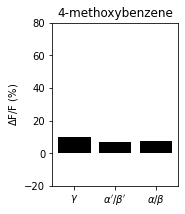

array([9.75052854, 6.89933252, 7.49983307])

In [73]:
col_colors = pd.DataFrame(fafb_kc_type_class,FAFB_connection_table.index)
### Function Definitions

def compute_response(DoOr_matrix=DoOr, connection_df=con_df, normalize=True, threshold=-1):
    """
    Compute the KC response matrix given a DoOr stimulus-response matrix.

    Parameters:
        DoOr_matrix (pd.DataFrame): Stimulus-response matrix for ORNs.
        connection_df (pd.DataFrame): Connection matrix from ORNs to KCs.
        normalize (bool): Normalize KC response by total claw count.
        threshold (int): If -1, return full response matrix; else apply threshold.

    Returns:
        pd.DataFrame: KC response matrix.
    """
    # Filter and process DoOr matrix
    df = DoOr_matrix.loc[target_odors, target_ORNs].clip(lower=0)
    df.columns = orn2g_only_door['g']

    # Compute KC response
    kc_response = df.fillna(0) @ connection_df[df.columns].T
    if normalize:
        kc_response /= connection_df.T.sum()

    if threshold == -1:
        return kc_response
    else:
        thresholded_response = kc_response.copy()
        for i in range(len(kc_response)):
            response_row = kc_response.iloc[i]
            min_activity = response_row.sort_values(ascending=False).iloc[threshold - 1]
            thresholded_response.iloc[i][response_row < min_activity] = 0
        return thresholded_response

response_df = compute_response(connection_df=FAFB_connection_table)

def effective_response(response_matrix=response_df, odor_name='4-methoxybenzene', 
                       kc_indices=[2, 1], plot_response=True, threshold=-1):
    """
    Calculate and optionally plot the effective KC response for a given odor.

    Parameters:
        response_matrix (pd.DataFrame): KC response matrix.
        odor_name (str): Name of the odor to analyze.
        kc_indices (list of int): Indices of KCs to include in the analysis.
        plot_response (bool): Plot the response bar chart.
        threshold (int): Activity threshold for KC response (not used in this version).

    Returns:
        np.ndarray: Array of effective KC responses.
    """
    odor_key = odor.loc[odor['Name'] == odor_name, 'InChIKey'].values[0]
    odor_response = response_matrix.loc[odor_key]

    kc_color_map = col_colors.iloc[:, 0][odor_response.index]
    normalization_factor = 41 / (41 - DoOr.loc[odor_key, orn2g_only_door['orn']].isnull().sum())

    kc_response = np.zeros(3)
    kc_groups = [['KCg'],["KCa'b'"],['KCab']]

    for idx, group in enumerate(kc_groups):
        target_kcs = kc_color_map.index[kc_color_map.isin(group)]
        kc_response[idx] = odor_response[target_kcs].mean()
    
    kc_response *= 100 * normalization_factor

    # Plot response if requested
    if plot_response:
        plt.figure(figsize=(0.75 * len(kc_indices), 3))
        x_labels = [r"$\gamma$", r"$\alpha'/\beta'$", r"$\alpha/\beta$"]
        plt.bar(np.array(x_labels)[kc_indices], kc_response[kc_indices], color='k')
        plt.ylabel(r'$\Delta$F/F (%)')
        plt.title(odor_name)
        plt.ylim(-20, 80)
        plt.show()

    return kc_response

# Example Usage
effective_response(kc_indices=[0, 1, 2])
